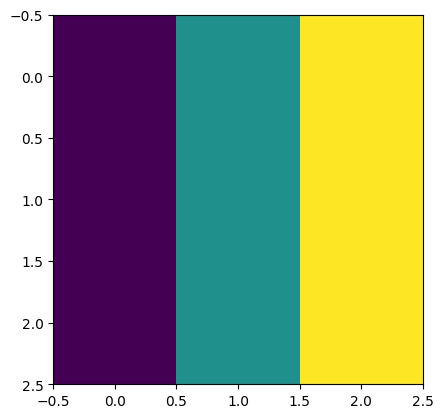

In [46]:
import matplotlib.pyplot as plt
plt.imshow([[1,2,3],[1,2,3],[1,2,3]])
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

import torch.optim as optim

import pandas as pd

from torchsummary import summary

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100
measure_freq = 50 # 10000 // batch_size
transform = transforms.ToTensor()

In [49]:
# Ported MNIST dataset 
class MNISTDataset(Dataset):
    def __init__(self, root="./data", train=True):
        self.train = train
        self.data = MNIST(root=root, train=train, download=True, transform=transform)
        self.data = [(torch.Tensor(image).to(device), torch.tensor(label).to(device)) for image, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [50]:
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
# trainset = MNISTDataset(train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)

testset = MNIST(root='./data', train=False, download=False, transform=transform)
# testset = MNISTDataset(train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=6)

In [51]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 128),
            nn.ReLU()
        )
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [52]:
def test(model, testloader):
    model.to(device)
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
        
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [53]:
def train(model, trainloader, testloader, loss, optimizer, epoches = 5):
    model.to(device)
    model.train()

    train_loss = []
    train_acc = []
    test_acc = []
    measure_steps = []

    iter_amount = len(trainloader)
    for epoch in range(epoches):
        print(f"Epoch {epoch+1}")
        iter_num = 1

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            l = loss(outputs, labels)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
            predicted = torch.max(outputs.data, 1)[1]
            acc = (predicted == labels).sum().item() / labels.size(0)
            
            if not (iter_num % measure_freq):
                train_loss.append(l.item())
                train_acc.append(acc)
                test_acc.append(test(model, testloader))
                model.train()
                measure_steps.append(epoch * iter_amount + iter_num)
                print(f"Step {iter_num:3}/{iter_amount} | Loss {l.item():.3f} | Train Acc {train_acc[-1]*100:.2f}% | Test Acc {test_acc[-1]*100:.2f}%")
            iter_num += 1
        print()

    return train_loss, train_acc, test_acc, measure_steps

In [54]:
def draw_acc(train_acc, test_acc, measure_steps, w = 10):
    plt.plot(measure_steps, pd.Series(train_acc).rolling(w).mean(), label="Train")
    plt.plot(measure_steps, pd.Series(test_acc).rolling(w).mean(), label="Test")
    plt.legend()
    plt.title(f"Rolling mean (window: {w}) Accuracy every {measure_freq} steps")
    plt.grid(True)
    plt.show()

def draw_loss(train_loss, measure_steps, w = 10):
    plt.title(f"Rolling mean (window: {w}) Train loss every {measure_freq} steps")
    plt.plot(measure_steps, pd.Series(train_loss).rolling(w).mean())
    plt.grid(True)
    plt.show()

# MNIST with random weights

In [55]:
model = MnistModel()
train_loss, train_acc, test_acc, measure_steps = train(model, trainloader, testloader, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.0015, momentum=0.9))

Epoch 1
Step  50/600 | Loss 2.288 | Train Acc 28.00% | Test Acc 23.72%
Step 100/600 | Loss 2.262 | Train Acc 44.00% | Test Acc 46.11%
Step 150/600 | Loss 2.207 | Train Acc 52.00% | Test Acc 43.86%
Step 200/600 | Loss 2.085 | Train Acc 57.00% | Test Acc 56.04%
Step 250/600 | Loss 1.710 | Train Acc 56.00% | Test Acc 63.84%
Step 300/600 | Loss 0.969 | Train Acc 71.00% | Test Acc 77.36%
Step 350/600 | Loss 0.506 | Train Acc 84.00% | Test Acc 82.72%
Step 400/600 | Loss 0.642 | Train Acc 80.00% | Test Acc 86.80%
Step 450/600 | Loss 0.399 | Train Acc 86.00% | Test Acc 87.92%
Step 500/600 | Loss 0.295 | Train Acc 93.00% | Test Acc 88.23%
Step 550/600 | Loss 0.320 | Train Acc 91.00% | Test Acc 89.72%
Step 600/600 | Loss 0.342 | Train Acc 91.00% | Test Acc 90.41%

Epoch 2
Step  50/600 | Loss 0.319 | Train Acc 89.00% | Test Acc 90.29%
Step 100/600 | Loss 0.411 | Train Acc 86.00% | Test Acc 91.42%
Step 150/600 | Loss 0.223 | Train Acc 92.00% | Test Acc 91.50%
Step 200/600 | Loss 0.233 | Train Acc 

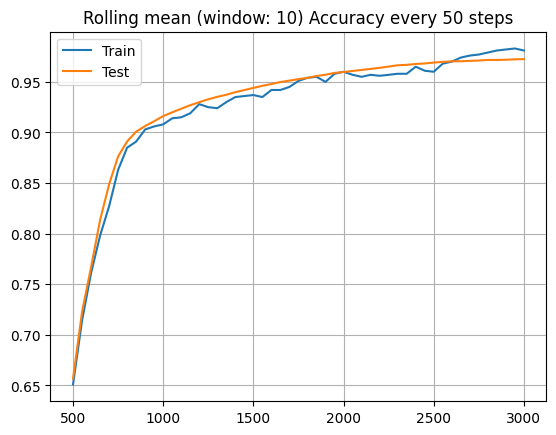

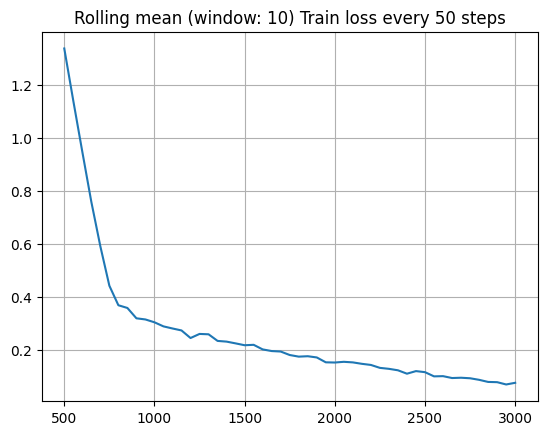

In [56]:
draw_acc(train_acc, test_acc, measure_steps)
draw_loss(train_loss, measure_steps)

In [57]:
torch.save(model.state_dict(), "./mnist_net.pt")

In [58]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 454,922
Trainable params: 454,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.74
Estimated Total Size (MB): 2.39
-------------------------------------------

# Fashion MNIST with random weights

In [59]:
trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)

testset = FashionMNIST(root='./data', train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=6)

In [60]:
model = MnistModel()
train_loss, train_acc, test_acc, measure_steps = train(model, trainloader, testloader, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.0015, momentum=0.95))

Epoch 1
Step  50/600 | Loss 2.197 | Train Acc 48.00% | Test Acc 42.16%
Step 100/600 | Loss 1.301 | Train Acc 53.00% | Test Acc 52.14%
Step 150/600 | Loss 0.886 | Train Acc 64.00% | Test Acc 59.31%
Step 200/600 | Loss 0.836 | Train Acc 68.00% | Test Acc 70.45%
Step 250/600 | Loss 0.770 | Train Acc 71.00% | Test Acc 72.44%
Step 300/600 | Loss 0.766 | Train Acc 72.00% | Test Acc 71.74%
Step 350/600 | Loss 0.830 | Train Acc 74.00% | Test Acc 75.26%
Step 400/600 | Loss 0.544 | Train Acc 83.00% | Test Acc 73.49%
Step 450/600 | Loss 0.805 | Train Acc 72.00% | Test Acc 73.60%
Step 500/600 | Loss 0.541 | Train Acc 77.00% | Test Acc 74.31%
Step 550/600 | Loss 0.712 | Train Acc 71.00% | Test Acc 74.98%
Step 600/600 | Loss 0.577 | Train Acc 76.00% | Test Acc 76.04%

Epoch 2
Step  50/600 | Loss 0.704 | Train Acc 74.00% | Test Acc 73.67%
Step 100/600 | Loss 0.569 | Train Acc 78.00% | Test Acc 77.06%
Step 150/600 | Loss 0.561 | Train Acc 77.00% | Test Acc 78.01%
Step 200/600 | Loss 0.508 | Train Acc 

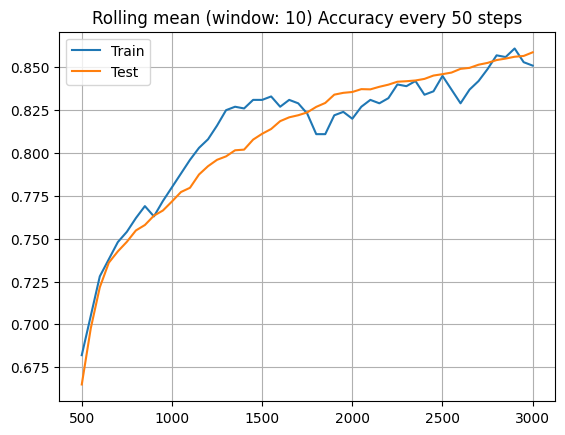

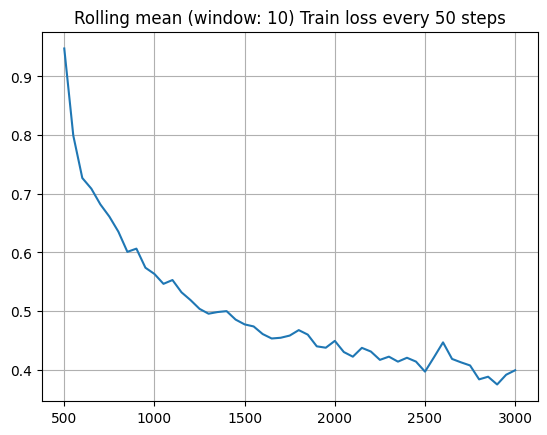

In [61]:
draw_acc(train_acc, test_acc, measure_steps)
draw_loss(train_loss, measure_steps)

# Fashion MNIST with trained MNIST weights

In [62]:
model = MnistModel()
model.load_state_dict(torch.load("./mnist_net.pt"))
train_loss, train_acc, test_acc, measure_steps = train(model, trainloader, testloader, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.0015, momentum=0.95))

Epoch 1
Step  50/600 | Loss 0.951 | Train Acc 65.00% | Test Acc 66.87%
Step 100/600 | Loss 0.683 | Train Acc 74.00% | Test Acc 73.20%
Step 150/600 | Loss 0.602 | Train Acc 81.00% | Test Acc 75.07%
Step 200/600 | Loss 0.546 | Train Acc 80.00% | Test Acc 76.63%
Step 250/600 | Loss 0.551 | Train Acc 82.00% | Test Acc 79.23%
Step 300/600 | Loss 0.503 | Train Acc 84.00% | Test Acc 79.30%
Step 350/600 | Loss 0.777 | Train Acc 72.00% | Test Acc 78.88%
Step 400/600 | Loss 0.463 | Train Acc 85.00% | Test Acc 78.93%
Step 450/600 | Loss 0.557 | Train Acc 79.00% | Test Acc 82.03%
Step 500/600 | Loss 0.325 | Train Acc 90.00% | Test Acc 81.55%
Step 550/600 | Loss 0.458 | Train Acc 80.00% | Test Acc 82.61%
Step 600/600 | Loss 0.677 | Train Acc 81.00% | Test Acc 83.19%

Epoch 2
Step  50/600 | Loss 0.509 | Train Acc 84.00% | Test Acc 83.34%
Step 100/600 | Loss 0.531 | Train Acc 80.00% | Test Acc 83.72%
Step 150/600 | Loss 0.491 | Train Acc 84.00% | Test Acc 83.59%
Step 200/600 | Loss 0.375 | Train Acc 

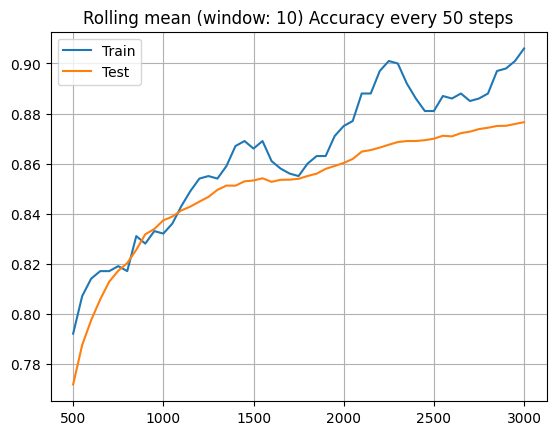

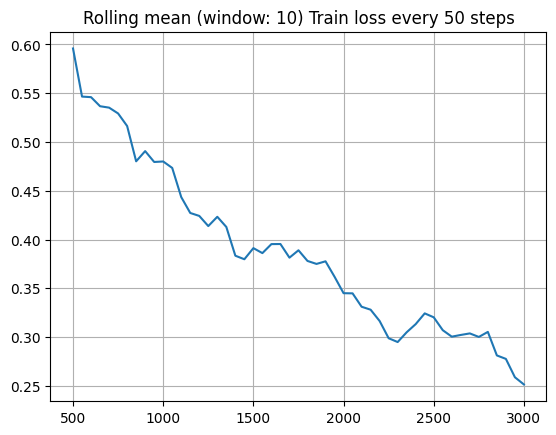

In [63]:
draw_acc(train_acc, test_acc, measure_steps)
draw_loss(train_loss, measure_steps)

# Fashion MNIST with trained MNIST weights and frozen conv. layers

In [64]:
model = MnistModel()
model.load_state_dict(torch.load("./mnist_net.pt"))

for param in model.conv1.parameters(): param.requires_grad = False

for param in model.conv2.parameters(): param.requires_grad = False

train_loss, train_acc, test_acc, measure_steps = train(model, trainloader, testloader, nn.CrossEntropyLoss(), optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=0.0015, momentum=0.95))


Epoch 1
Step  50/600 | Loss 0.891 | Train Acc 69.00% | Test Acc 69.28%
Step 100/600 | Loss 0.719 | Train Acc 74.00% | Test Acc 75.49%
Step 150/600 | Loss 0.589 | Train Acc 80.00% | Test Acc 75.68%
Step 200/600 | Loss 0.571 | Train Acc 76.00% | Test Acc 77.86%
Step 250/600 | Loss 0.454 | Train Acc 84.00% | Test Acc 77.70%
Step 300/600 | Loss 0.631 | Train Acc 75.00% | Test Acc 78.51%
Step 350/600 | Loss 0.601 | Train Acc 79.00% | Test Acc 79.18%
Step 400/600 | Loss 0.542 | Train Acc 76.00% | Test Acc 77.53%
Step 450/600 | Loss 0.605 | Train Acc 71.00% | Test Acc 80.87%
Step 500/600 | Loss 0.467 | Train Acc 83.00% | Test Acc 80.83%
Step 550/600 | Loss 0.654 | Train Acc 77.00% | Test Acc 79.92%
Step 600/600 | Loss 0.540 | Train Acc 80.00% | Test Acc 81.46%

Epoch 2
Step  50/600 | Loss 0.537 | Train Acc 79.00% | Test Acc 80.94%
Step 100/600 | Loss 0.532 | Train Acc 80.00% | Test Acc 81.03%
Step 150/600 | Loss 0.504 | Train Acc 77.00% | Test Acc 82.83%
Step 200/600 | Loss 0.471 | Train Acc 

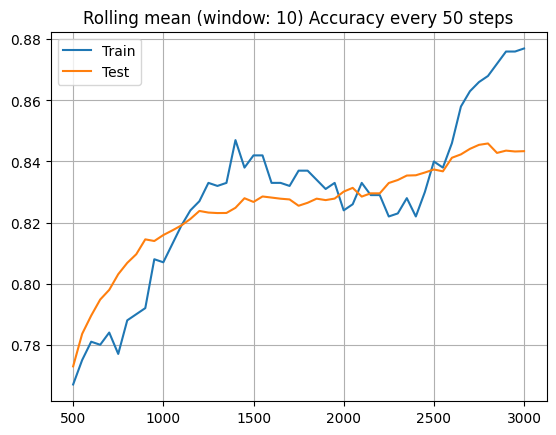

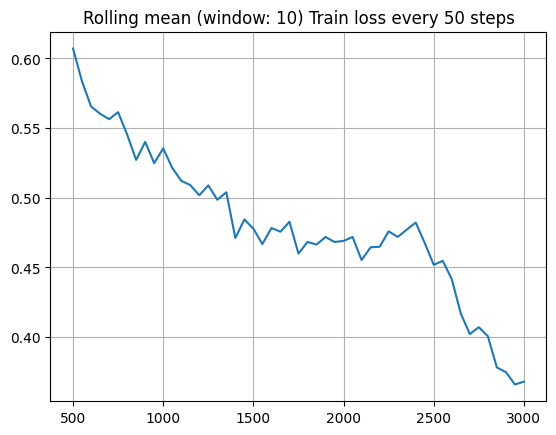

In [65]:
draw_acc(train_acc, test_acc, measure_steps)
draw_loss(train_loss, measure_steps)

# Fashion MNIST with trained MNIST weights and frozen until epoch 5 conv. layers

In [66]:
model = MnistModel()
model.load_state_dict(torch.load("./mnist_net.pt"))

for param in model.conv1.parameters(): param.requires_grad = False
for param in model.conv2.parameters(): param.requires_grad = False

optimizer = optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=0.0015, momentum=0.95)
loss = nn.CrossEntropyLoss()

model.to(device)
model.train()

train_loss = []
train_acc = []
test_acc = []
measure_steps = []

iter_amount = len(trainloader)
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    iter_num = 1

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        l = loss(outputs, labels)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
        predicted = torch.max(outputs.data, 1)[1]
        acc = (predicted == labels).sum().item() / labels.size(0)
        
        if not (iter_num % measure_freq):
            train_loss.append(l.item())
            train_acc.append(acc)
            test_acc.append(test(model, testloader))
            model.train()
            measure_steps.append(epoch * iter_amount + iter_num)
            print(f"Step {iter_num:3}/{iter_amount} | Loss {l.item():.3f} | Train Acc {train_acc[-1]*100:.2f}% | Test Acc {test_acc[-1]*100:.2f}%")
        iter_num += 1
    print()
    
    if epoch == 1:
        for param in model.conv1.parameters(): param.requires_grad = True
        for param in model.conv2.parameters(): param.requires_grad = True


Epoch 1
Step  50/600 | Loss 0.807 | Train Acc 67.00% | Test Acc 65.32%
Step 100/600 | Loss 0.726 | Train Acc 73.00% | Test Acc 71.46%
Step 150/600 | Loss 0.741 | Train Acc 73.00% | Test Acc 75.67%
Step 200/600 | Loss 0.626 | Train Acc 78.00% | Test Acc 76.74%
Step 250/600 | Loss 0.637 | Train Acc 73.00% | Test Acc 77.15%
Step 300/600 | Loss 0.478 | Train Acc 79.00% | Test Acc 78.26%
Step 350/600 | Loss 0.568 | Train Acc 84.00% | Test Acc 78.18%
Step 400/600 | Loss 0.537 | Train Acc 83.00% | Test Acc 79.00%
Step 450/600 | Loss 0.426 | Train Acc 86.00% | Test Acc 79.45%
Step 500/600 | Loss 0.418 | Train Acc 83.00% | Test Acc 79.61%
Step 550/600 | Loss 0.594 | Train Acc 77.00% | Test Acc 79.34%
Step 600/600 | Loss 0.536 | Train Acc 80.00% | Test Acc 79.94%

Epoch 2
Step  50/600 | Loss 0.382 | Train Acc 87.00% | Test Acc 81.16%
Step 100/600 | Loss 0.531 | Train Acc 80.00% | Test Acc 81.18%
Step 150/600 | Loss 0.489 | Train Acc 80.00% | Test Acc 80.51%
Step 200/600 | Loss 0.726 | Train Acc 

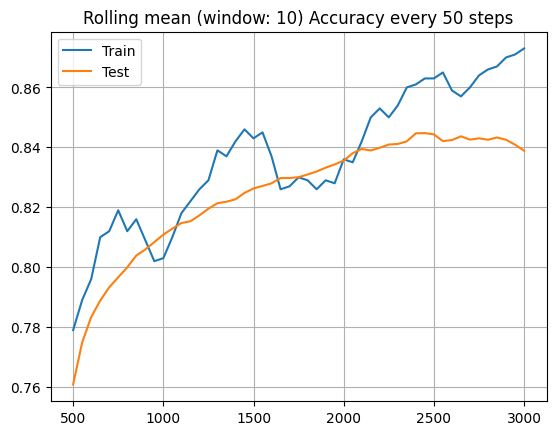

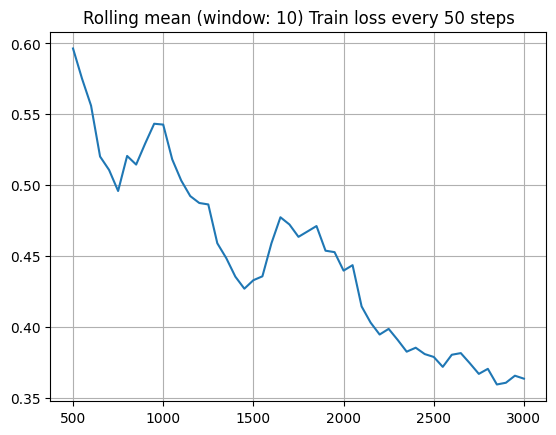

In [67]:
draw_acc(train_acc, test_acc, measure_steps)
draw_loss(train_loss, measure_steps)